# GraphVelo demo

In this tutorial, we will show GraphVelo serves as a plugin designed to seamlessly integrate into existing RNA velocity analysis pipelines.

GraphVelo exploits the nature of the low-dimensional cell state manifold to refine the estimated RNA velocity to satisfy the tangent space constraint on the velocity vectors.  

In [1]:
import scanpy as sc
import scvelo as scv
import cellrank as cr

from graphvelo.utils import mack_score, adj_to_knn
from graphvelo.graph_velocity import GraphVelo
from graphvelo.plot import gene_score_histogram

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [2]:
cr.logging.print_versions()

cellrank==2.0.4 scanpy==1.9.8 anndata==0.9.2 numpy==1.24.4 numba==0.58.1 scipy==1.10.1 pandas==2.0.3 pygpcca==1.0.4 scikit-learn==1.3.2 statsmodels==0.14.1 python-igraph==0.10.8 scvelo==0.3.2 pygam==0.9.1 matplotlib==3.7.5 seaborn==0.13.2


In [3]:
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Preprocess the data

In [4]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/anaconda3/envs/graphvelo-release/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Velocity estimation

In [5]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata)

recovering dynamics (using 10/10 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

    finished (0:00:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


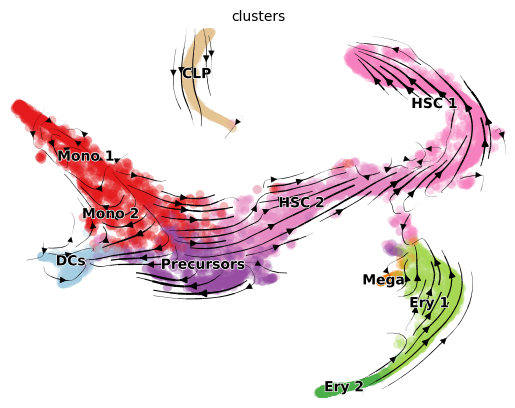

In [6]:
scv.pl.velocity_embedding_stream(adata, color='clusters', basis='tsne')

## Convert adjacency matrix to kNN format for graphvelo processing

If you calculate the neighbor graph via dyn.tl.neighbor(), please skip this step. 

In [7]:
indices, _ = adj_to_knn(adata.obsp['connectivities'])
adata.uns['neighbors']['indices'] = indices

## Calculate MacK score

This step is important for robustly estimated gene selection and removes misleading velocity genes with changed transcription/degradation rate

In [8]:
mack_score(adata, ekey='Ms', vkey='velocity', tkey='palantir_pseudotime')

calculating manifold-consistent scores in 10 cpu(s): 100%|██████████| 588/588 [02:54<00:00,  3.37it/s]


Then you can diagnosnose the velocity genes by checking the mack score and fit likelihood estimated by any methods, 
For example, we check ANGPT1 and RBPMS in this analysis and find they have a low mack score and high fit likelihood,
indicating that they may be the misleading genes that distort the true vector field.

This is probably cause by the coordinate changes of kinetic rates like transcription rate or degradation rate.

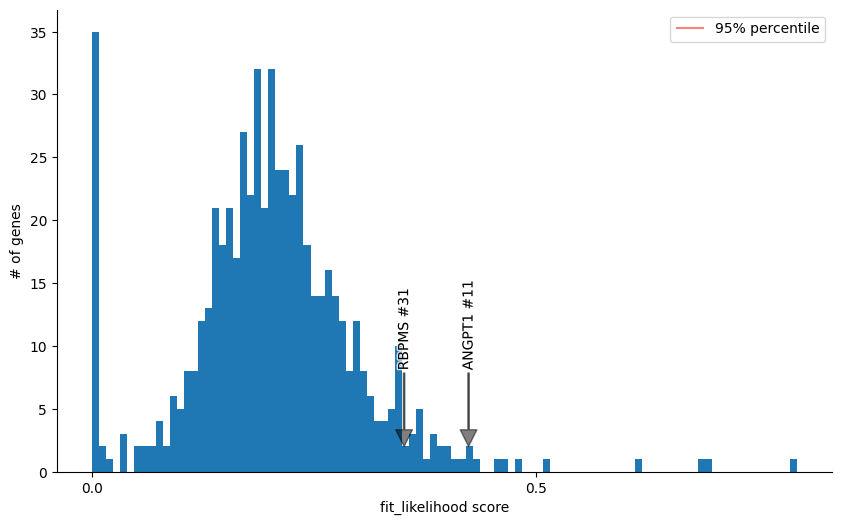

In [9]:
gene_score_histogram(adata, 'fit_likelihood', genes = ['ANGPT1', 'RBPMS'], bins=100)
plt.show()

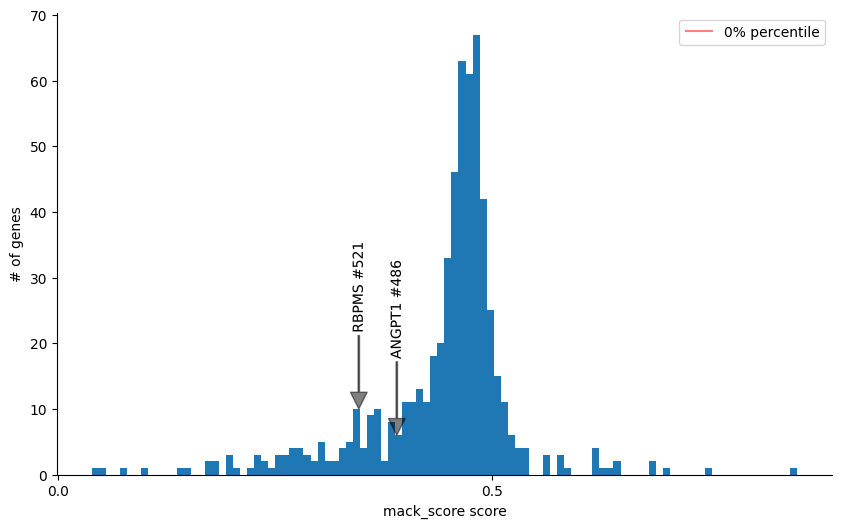

In [10]:
gene_score_histogram(adata, 'mack_score', genes = ['ANGPT1', 'RBPMS'], bins=100, quantile=False)
plt.show()

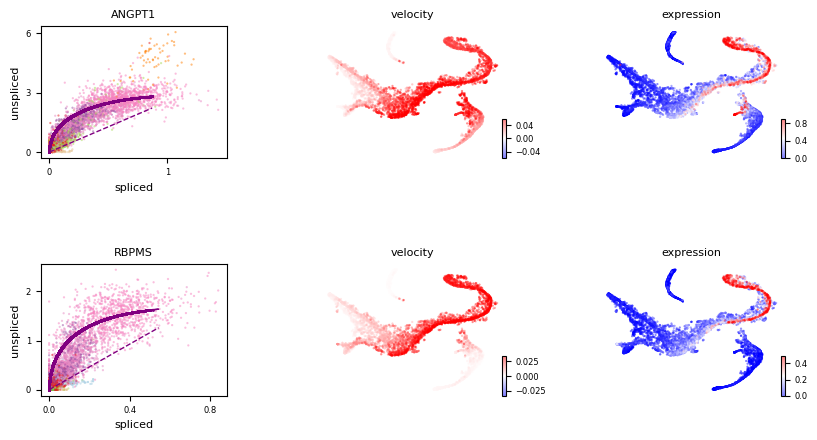

In [11]:
scv.pl.velocity(adata, var_names=['ANGPT1', 'RBPMS'], color_map='bwr')

In [12]:
confident_genes = adata.var['mack_score'].sort_values(ascending=False)[:100].index

## Apply GraphVelo to refine manifold-constrained velocity vectors

In [13]:
gv = GraphVelo(adata, gene_subset=confident_genes, xkey='Ms', vkey='velocity')
gv.train()
adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['Ms'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_tsne'] = gv.project_velocity(adata.obsm['X_tsne'])

Learning Phi in tangent space projection.: 100%|██████████| 5780/5780 [00:02<00:00, 2514.76it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:09<00:00, 597.19it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 14397.96it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 5780/5780 [00:00<00:00, 17121.51it/s]


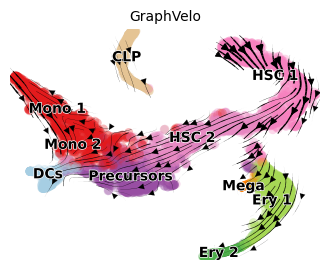

In [14]:
scv.pl.velocity_embedding_stream(adata, color='clusters', basis='tsne', X=adata.obsm['X_tsne'], V=adata.obsm['gv_tsne'], title='GraphVelo', figsize=(4,3))

## Incorporating with CellRank

  0%|          | 0/5780 [00:00<?, ?cell/s]

  0%|          | 0/5780 [00:00<?, ?cell/s]

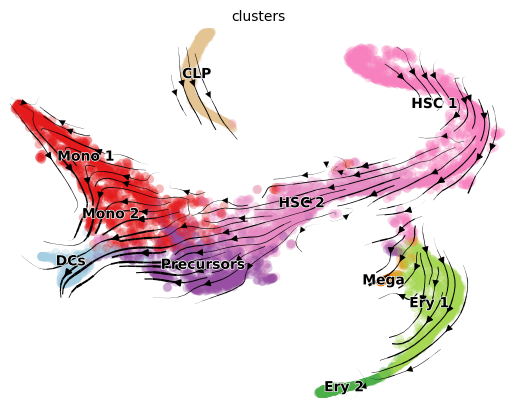

In [15]:
terminal_states = [
        "Mono_1",
        "Ery_2_2",
        "DCs",
        "Mega",
        "CLP"
    ]
vk = cr.kernels.VelocityKernel(adata, attr='obsm', xkey='X_pca', vkey='gv_pca')
vk.compute_transition_matrix()
vk.plot_projection(basis='tsne')

Defaulting to `'gmres'` solver.


  0%|          | 0/5 [00:00<?, ?/s]

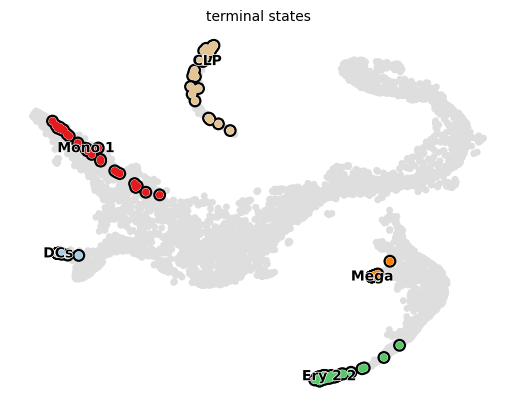

In [16]:
g_raw = cr.estimators.GPCCA(vk)
g_raw.compute_macrostates(n_states=10,cluster_key="clusters")
g_raw.set_terminal_states(terminal_states)
g_raw.compute_fate_probabilities()
g_raw.plot_macrostates(which="terminal", s=100)

## Finished